# Neural Network (MLP) – Wine Quality (binaire)

Ce notebook applique un **réseau de neurones (MLP - Multi-Layer Perceptron)** sur le dataset Wine Quality :
- Classification binaire : quality ≥6 → bon, <6 → moyen/mauvais
- Architecture adaptée aux données tabulaires de taille modérée (~1600 échantillons)
- Régularisation (early stopping, L2) pour limiter le surajustement
- Suivi avec MLflow

## 1. Imports et configuration

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
# Racine du projet (dossier contenant src/ et dataset/)
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable. Ouvrez le projet ML-project.")
from preprocessing import load_data, clean_data, scale_features, split_data
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("sqlite:///c:/Users/pc/Desktop/ML-project/classification/mlflow.db")
mlflow.set_experiment("wine-quality-neural-network")

<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/classification/mlruns/8', creation_time=1771083675102, experiment_id='8', last_update_time=1771083675102, lifecycle_stage='active', name='wine-quality-neural-network', tags={}>

## 2. Chargement et preprocessing

In [8]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

df["quality_binary"] = (df["quality"] >= 6).astype(int)

X = df.drop(columns=["quality", "quality_binary"])
y = df["quality_binary"]

X_scaled, scaler = scale_features(X)
X_train, X_test, y_train, y_test = split_data(X_scaled, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")

Train: 1087, Test: 272
Features: 11


## 3. Modèle MLP – architecture et entraînement

In [9]:
# MLP adapté aux petits jeux de données : 2 couches cachées, early stopping
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42
)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Nombre d'itérations: {mlp.n_iter_}")
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

Accuracy: 0.761
F1-score: 0.774
Precision: 0.776
Recall: 0.771
Nombre d'itérations: 34

Matrice de confusion:
[[ 96  32]
 [ 33 111]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       128
           1       0.78      0.77      0.77       144

    accuracy                           0.76       272
   macro avg       0.76      0.76      0.76       272
weighted avg       0.76      0.76      0.76       272



## 4. Courbe de loss et courbe ROC

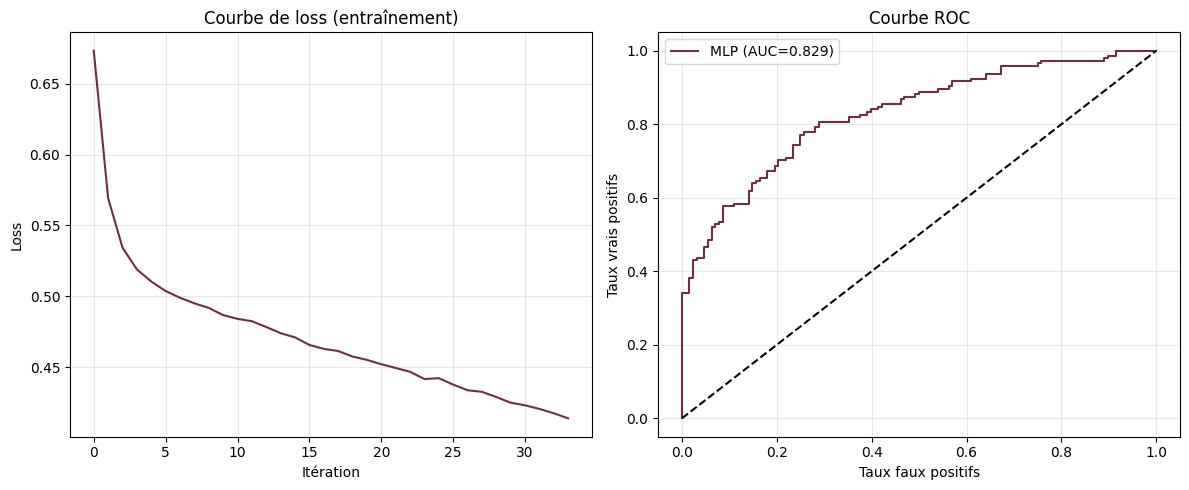

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss curve (sklearn stocke la loss à chaque iteration)
if hasattr(mlp, 'loss_curve_') and mlp.loss_curve_ is not None:
    axes[0].plot(mlp.loss_curve_, color='#722F37')
    axes[0].set_xlabel('Itération')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Courbe de loss (entraînement)')
    axes[0].grid(True, alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'Loss curve non disponible', ha='center', va='center')

# ROC
y_proba = mlp.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
axes[1].plot(fpr, tpr, label=f'MLP (AUC={auc_score:.3f})', color='#722F37')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('Taux faux positifs')
axes[1].set_ylabel('Taux vrais positifs')
axes[1].set_title('Courbe ROC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('neuralnetwork_curves.png')
plt.show()

## 5. Matrice de confusion

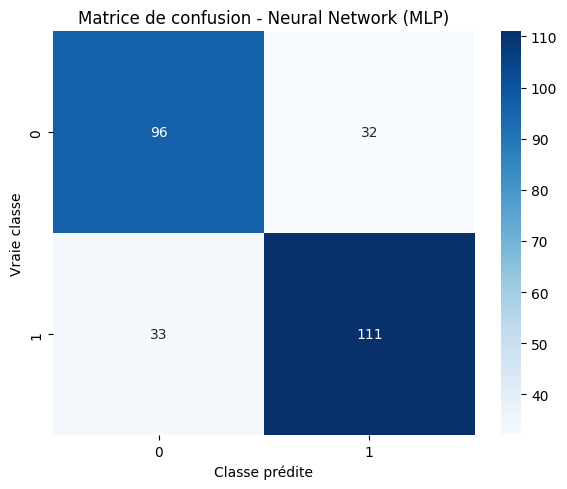

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion - Neural Network (MLP)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.savefig('neuralnetwork_confusion_matrix.png')
plt.show()

## 6. MLflow tracking

In [12]:
with mlflow.start_run(run_name="MLP_binary"):
    mlflow.log_param("hidden_layer_sizes", str((64, 32)))
    mlflow.log_param("activation", "relu")
    mlflow.log_param("solver", "adam")
    mlflow.log_param("alpha", 0.001)
    mlflow.log_param("max_iter", 500)
    mlflow.log_param("early_stopping", True)
    mlflow.log_metric("accuracy", float(acc))
    mlflow.log_metric("f1_score", float(f1))
    mlflow.log_metric("roc_auc", float(auc_score))
    mlflow.log_metric("n_iter", int(mlp.n_iter_))
    mlflow.log_artifact('neuralnetwork_confusion_matrix.png')
    mlflow.log_artifact('neuralnetwork_curves.png')
    mlflow.sklearn.log_model(mlp, "mlp_model")
    print("MLflow run terminé")

2026/02/14 17:14:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


MLflow run terminé
